In [238]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn.svm import LinearSVR
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

In [75]:
fonte = "https://github.com/alura-cursos/imersao-dados-2-2020/blob/master/MICRODADOS_ENEM_2019_SAMPLE_43278.csv?raw=true"
dados = pd.read_csv(fonte)

In [103]:
provas = ["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_MT", "NU_NOTA_LC", "NU_NOTA_REDACAO"]

In [102]:
dados["NU_NOTA_TOTAL"] = dados[provas].sum(axis=1)
dados.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,...,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_TOTAL
0,190001004661,2019,1506138,Redenção,15,PA,17,M,1,3,1,1506138.0,Redenção,15.0,PA,3,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,99999CCCABBCAADDBCEBCCADBEEBDECBAABDEACACAEABB...,DEEDCAECDDEEECBCBECABEBAECBBCDAECAEBBBBBDCCDB,1,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB,EBBADCABDABACBCEBDEEAAADDBECDECDDBADBCDAAECBCC...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,60.0,100.0,80.0,80.0,100.0,420.0,B,B,A,A,4,B,A,C,B,A,C,B,A,A,A,A,A,A,A,B,A,C,A,B,B,2288.9
1,190001004674,2019,1504208,Marabá,15,PA,23,M,1,3,1,1504208.0,Marabá,15.0,PA,1,3,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,99999ABCEBCEDDECEEEBBCCEECCABDABEEBCDEAEBBEAEA...,NaN,1,NaN,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,NaN,1.0,80.0,100.0,80.0,80.0,60.0,400.0,C,C,A,A,4,B,A,B,C,A,A,B,B,B,A,A,A,A,B,A,A,B,A,A,B,1184.6
2,190001004722,2019,1501402,Belém,15,PA,35,F,2,1,1,1501402.0,Belém,15.0,PA,1,12,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,99999ECBCECEBBABECCCECECCEECCDECEEEDADDDDECEDD...,DDBEADEBBCADCEEACABECBCEBADECADCEDAACBDABABCE,1,AAECACDEADCBCDDDBCBDADAEABCEBABEEBCBEECEBDADC,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,EEEADBEBACABCDBABECECACDCBDCCEDCDABEDECDDDBAA,1.0,100.0,120.0,120.0,100.0,120.0,560.0,C,A,B,B,5,C,A,B,C,A,A,B,A,B,A,A,A,A,B,A,B,B,A,A,B,2350.5
3,190001004735,2019,1507300,São Félix do Xingu,15,PA,23,F,1,3,1,1505437.0,Ourilândia do Norte,15.0,PA,1,7,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,99999BABCDABBCBDDAAECADBDDADDCBCEEDCAEBCEAEABD...,CBDEBBCBDEBCABCDBDEDADCCBEDBCAECEBEBDEBAEECBC,1,BEEAAEBEEBADEADDADAEABCEDDDBCBCBCCACBCDADCCEB,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,BEDEEEAADBEBACABCDBABECECACADCBDCCEDCDABECDDD,1.0,100.0,120.0,120.0,120.0,40.0,500.0,E,C,A,A,1,B,A,B,C,A,A,B,A,A,A,A,A,A,B,A,A,B,A,A,B,2555.7
4,190001004776,2019,1500800,Ananindeua,15,PA,16,F,1,3,1,1500800.0,Ananindeua,15.0,PA,3,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,EBCAB99999BBCECBCACBEACBDAABDBCBBDACEBBACDCAEC...,AECCBBCBBCBDEDECACBAABEDABBEDDADCEADDBEBDBBEB,0,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB,EBBADCABDABACBCEBDEEAAADDBECDECDDBADBCDAAECBCC...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,160.0,140.0,160.0,160.0,160.0,780.0,E,E,B,D,3,E,A,B,C,B,A,B,A,A,A,A,A,A,B,A,A,D,A,A,B,2803.5


In [104]:
dados_sem_nota_zero = dados.query("NU_NOTA_TOTAL != 0")
dados_sem_nota_zero.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,...,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_TOTAL
0,190001004661,2019,1506138,Redenção,15,PA,17,M,1,3,1,1506138.0,Redenção,15.0,PA,3,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,99999CCCABBCAADDBCEBCCADBEEBDECBAABDEACACAEABB...,DEEDCAECDDEEECBCBECABEBAECBBCDAECAEBBBBBDCCDB,1,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB,EBBADCABDABACBCEBDEEAAADDBECDECDDBADBCDAAECBCC...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,60.0,100.0,80.0,80.0,100.0,420.0,B,B,A,A,4,B,A,C,B,A,C,B,A,A,A,A,A,A,A,B,A,C,A,B,B,2288.9
1,190001004674,2019,1504208,Marabá,15,PA,23,M,1,3,1,1504208.0,Marabá,15.0,PA,1,3,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,99999ABCEBCEDDECEEEBBCCEECCABDABEEBCDEAEBBEAEA...,NaN,1,NaN,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,NaN,1.0,80.0,100.0,80.0,80.0,60.0,400.0,C,C,A,A,4,B,A,B,C,A,A,B,B,B,A,A,A,A,B,A,A,B,A,A,B,1184.6
2,190001004722,2019,1501402,Belém,15,PA,35,F,2,1,1,1501402.0,Belém,15.0,PA,1,12,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,99999ECBCECEBBABECCCECECCEECCDECEEEDADDDDECEDD...,DDBEADEBBCADCEEACABECBCEBADECADCEDAACBDABABCE,1,AAECACDEADCBCDDDBCBDADAEABCEBABEEBCBEECEBDADC,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,EEEADBEBACABCDBABECECACDCBDCCEDCDABEDECDDDBAA,1.0,100.0,120.0,120.0,100.0,120.0,560.0,C,A,B,B,5,C,A,B,C,A,A,B,A,B,A,A,A,A,B,A,B,B,A,A,B,2350.5
3,190001004735,2019,1507300,São Félix do Xingu,15,PA,23,F,1,3,1,1505437.0,Ourilândia do Norte,15.0,PA,1,7,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,99999BABCDABBCBDDAAECADBDDADDCBCEEDCAEBCEAEABD...,CBDEBBCBDEBCABCDBDEDADCCBEDBCAECEBEBDEBAEECBC,1,BEEAAEBEEBADEADDADAEABCEDDDBCBCBCCACBCDADCCEB,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,BEDEEEAADBEBACABCDBABECECACADCBDCCEDCDABECDDD,1.0,100.0,120.0,120.0,120.0,40.0,500.0,E,C,A,A,1,B,A,B,C,A,A,B,A,A,A,A,A,A,B,A,A,B,A,A,B,2555.7
4,190001004776,2019,1500800,Ananindeua,15,PA,16,F,1,3,1,1500800.0,Ananindeua,15.0,PA,3,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,EBCAB99999BBCECBCACBEACBDAABDBCBBDACEBBACDCAEC...,AECCBBCBBCBDEDECACBAABEDABBEDDADCEADDBEBDBBEB,0,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB,EBBADCABDABACBCEBDEEAAADDBECDECDDBADBCDAAECBCC...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,160.0,140.0,160.0,160.0,160.0,780.0,E,E,B,D,3,E,A,B,C,B,A,B,A,A,A,A,A,A,B,A,A,D,A,A,B,2803.5


Problema: É possível prever a nota da prova de matemática baseando-se na nota das demais avaliações?

Primeiro, vamos separar o dataset entre dados de entrada e dados de saída.

In [206]:
provas_entradas = ["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_REDACAO"]
provas_saida = "NU_NOTA_MT"

dados_sem_nota_zero = dados_sem_nota_zero[provas].dropna()

notas_entrada = dados_sem_nota_zero[provas_entradas]
notas_saida = dados_sem_nota_zero[provas_saida]

Agora vamos dividir a base de dados entre dados de treinamento e dados de validação

In [208]:
SEED = 1234
x_treino, x_teste, y_treino, y_teste = train_test_split(notas_entrada, notas_saida, test_size=0.25, random_state=SEED)

Agora que temos a base de dados dividida entre treinamento e validação, vamos criar modelos de regreção.

In [196]:
modelo_SVR = LinearSVR(random_state=SEED)
modelo_dummy = DummyRegressor()
modelo_arvore = DecisionTreeRegressor(max_depth=3)

Agora é realizado o treinamento do modelo escolhido.

In [197]:
modelo_SVR.fit(x_treino, y_treino)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=1234, tol=0.0001, verbose=0)

In [198]:
modelo_dummy.fit(x_treino, y_treino)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [199]:
modelo_arvore.fit(x_treino, y_treino)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Agora vamos realizar uma predição nos modelos treinados

In [200]:
predicoes_SVR = modelo_SVR.predict(x_teste)
predicoes_dummy = modelo_dummy.predict(x_teste)
predicoes_arvore = modelo_arvore.predict(x_teste)

Agora vamos construir métricas para avaliar quantitativamente os modelos treinados:

Primeiro, vamos avaliar o modelo SVR

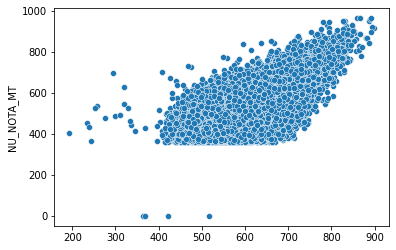

In [210]:
sns.scatterplot(x=predicoes, y=y_teste)

In [211]:
resultados_SVR=pd.DataFrame()
resultados_SVR["Real"] = y_teste
resultados_SVR["Previsao"] = predicoes_SVR
resultados_SVR["Diferenca"] = resultados_SVR["Real"] - resultados_SVR["Previsao"]
resultados_SVR["Quadrado_Diferenca"] = (resultados_SVR["Real"] - resultados_SVR["Previsao"])**2

resultados_SVR["Quadrado_Diferenca"].mean()**(1/2)

113.31350667922123

In [158]:
mean_squared_error(y_teste, predicoes_SVR)

12839.950795941917

Agora vamos avaliar o modelo Dummy

In [160]:
mean_squared_error(y_teste, predicoes_dummy)

11788.71263914587

In [161]:
mean_squared_error(y_teste, predicoes_dummy)**(1/2)

108.57583819223257

Avaliação do modelo baseado em arvores de decisão

In [173]:
mean_squared_error(y_teste, predicoes_arvore)

5993.166853528304

In [174]:
mean_squared_error(y_teste, predicoes_arvore)**(1/2)

77.41554658806139

In [ ]:
Vamos agora implementar uma forma de treinamento e validação mais robusta utilizando o Cross-Validation

In [255]:
def calcula_mse(score):
  media = (score["test_score"]*-1).mean()
  desvio_padrao = (score["test_score"]*-1).std()
  lim_inferior = media-(2*desvio_padrao)
  limite_superior = media + (2*desvio_padrao)

  print(f"Intervalo de confianã vai de {lim_inferior} ate {limite_superior}")

In [253]:
modelo_SVR = LinearSVR(random_state=SEED)
modelo_dummy = DummyRegressor()


In [267]:
def regressor_arvore(nivel):

  modelo_arvore = DecisionTreeRegressor(max_depth=nivel)

  SEED=1234
  np.random.seed(SEED)

  partes= KFold(n_splits=10, shuffle=True)
  score = cross_validate(modelo_arvore, x_treino, y_treino, cv=partes, scoring="neg_mean_squared_error", return_train_score=True)
  
  print(f"Média de cada KFold: Teste: {(score['test_score']*-1).mean()} Treino: {(score['train_score']*-1).mean()}")
  return score

Cálculo dos limites inferiores e superiores para se obter um intervalo de confiança

In [265]:
for i in range(1,5):
  score =  regressor_arvore(i)
  calcula_mse(score)

Média de cada KFold: 7893.874394161263
Intervalo de confianã vai de 7712.494436023109 ate 8075.2543522994165
Média de cada KFold: 6574.593626360982
Intervalo de confianã vai de 6439.828789356461 ate 6709.358463365503
Média de cada KFold: 6065.061348721948
Intervalo de confianã vai de 5958.660691149571 ate 6171.462006294325
Média de cada KFold: 5837.297680755236
Intervalo de confianã vai de 5740.154757029154 ate 5934.440604481318


In [ ]:
Vamos avaliar se conforme a profundidade da árvore aumenta é possível obter um melhor desempenho do classificador.

In [270]:
for i in range(1,20):
  regressor_arvore(i)

Média de cada KFold: Teste: 7893.874394161263 Treino: 7885.453547490273
Média de cada KFold: Teste: 6574.593626360982 Treino: 6553.784183823407
Média de cada KFold: Teste: 6065.061348721948 Treino: 6038.914371525696
Média de cada KFold: Teste: 5837.297680755236 Treino: 5777.2047261458265
Média de cada KFold: Teste: 5704.193949892853 Treino: 5607.751640730485
Média de cada KFold: Teste: 5606.4871685861035 Treino: 5471.273495257777
Média de cada KFold: Teste: 5574.910502578573 Treino: 5364.816951423703
Média de cada KFold: Teste: 5601.158289712913 Treino: 5259.003524257887
Média de cada KFold: Teste: 5692.085586728081 Treino: 5132.361729975941
Média de cada KFold: Teste: 5844.957884068245 Treino: 4964.541740824619
Média de cada KFold: Teste: 6078.754339347143 Treino: 4753.3901918543725
Média de cada KFold: Teste: 6344.2845359376715 Treino: 4496.6386531228345
Média de cada KFold: Teste: 6667.047753313125 Treino: 4202.715714627228
Média de cada KFold: Teste: 7005.726943914623 Treino: 3874.

Observamos que conforme a profundidade da arvore fica muito grande, existe uma melhora significativa no score dos dados de treinamento, enquanto que os dados de teste apresentam uma queda de desempenho significativa. Isto é um indicativo de que o regressor está com overffiting, ou seja, ele se adaptou demais aos dados de treinamento e com isso não consegue prever corretametne os dados do conjunto de teste.